In [1]:
import cv2
from torch import nn
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from IPython.display import Image
from matplotlib import pyplot as plt
import numpy

In [2]:
# set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)
# setup device cuda vs. cpu
# cuda = torch.cuda.is_available()
cuda = False
device = torch.device("cuda:0" if cuda else "cpu")

In [3]:
def to_grey_scale(x):
    return numpy.asarray(x.convert("L")).astype(numpy.float64)/256.0 

In [4]:
class ARM_VAE(nn.Module):
    def __init__(self, device, img_x, img_y, latent_size):
        super().__init__()
        self.__device = device
        self.__latent_size = latent_size
        self.IMG_X = img_x
        self.IMG_Y = img_y

        self.encoder = nn.Sequential(
            nn.Linear(self.IMG_Y * self.IMG_X, self.__latent_size ** 2).double(),
            nn.ReLU().double(),
            nn.Linear(self.__latent_size ** 2, self.__latent_size * 2).double()
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.__latent_size, self.__latent_size ** 2).double(),
            nn.ReLU().double(),
            nn.Linear(self.__latent_size ** 2, self.IMG_Y * self.IMG_X).double(),
            nn.Sigmoid().double(),
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
        mu_logvar = self.encoder(x.view(-1, self.IMG_Y * self.IMG_X)).view(-1, 2, self.__latent_size)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def sample(self, n_samples):
        z = torch.randn((n_samples, self.__latent_size)).to(self.__device)
        return self.decode(z)

    def to_device(self):
        self.to(self.__device)

In [5]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x, mu, logvar, IMG_X, IMG_Y):

    # reconstruction loss (pushing the points apart)
    BCE = nn.functional.cross_entropy(
        x_hat, x.view(-1, IMG_Y*IMG_X), reduction='sum'
    )

    # KL divergence loss (the relative entropy between two distributions a multivariate gaussian and a normal)
    # (enforce a radius of 1 in each direction + pushing the means towards zero)
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return BCE + KLD # we can use a beta parameter here (BCE + beta * KLD)

In [6]:
def create_empty_model():
    LATENT_SIZE = 20
    IMG_X = 640
    IMG_Y = 480
    return ARM_VAE(device,IMG_X, IMG_Y, LATENT_SIZE).to(device)

# performs one epoch of training and returns the training loss for this epoch
def train(model, optimizer):
    model.train()
    train_loss = 0
    for x, _ in bin_train_loader:
        x = x.to(device)
        # ===================forward=====================
        x_hat, mu, logvar = model(x)
        loss = loss_function(x_hat, x, mu, logvar,model.IMG_X,model.IMG_Y)
        train_loss += loss.item()
        print(f" loss={loss.item()} , total_loss={train_loss}")
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return train_loss

# evaluates the model on the test set
def test(model, epoch):
    means, logvars, labels, images = list(), list(), list(), list()
    test_loss = 0
    with torch.no_grad():
        model.eval()
        for x, y in bin_test_loader:
            x = x.to(device)
            # forward
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # log
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
            images.append(x.detach())
    display_images(None, x_hat, f'Epoch {epoch} - Reconstructed Images', 1)
    return test_loss, means, logvars, labels, images

In [8]:
def train_and_save_model(filename):
    LEARNING_RATE = 1e-3
    model = create_empty_model()
    epochs = 50
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
    )
    for epoch in range(1, epochs+1):
        # train for one epoch
        train_loss = train(model, optimizer)
        # print the train loss for the epoch
        print(f'====> Epoch: {epoch} Average train loss: {train_loss / len(bin_train_loader.dataset):.4f}')
    # save the state dict of the model
    torch.save(model.state_dict(), filename)

In [9]:
def load_model(filename):
    model = create_empty_model()
    model.load_state_dict(torch.load(filename))
    return model

In [10]:
# Load data from images sub-folder
bin_train_loader = DataLoader(ImageFolder('images',transform=to_grey_scale))
MODEL_FILE = 'arm-vae-model-all-images.pt'
#train_and_save_model(MODEL_FILE)

0.99609375, 307200


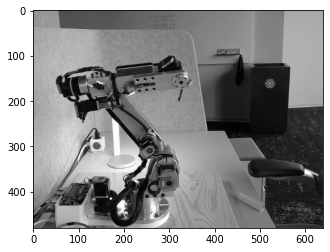

In [11]:
image = bin_train_loader.dataset[0][0]
print(f"{image.max()}, {image.size}")
plt.imshow(image,cmap='gray')

In [12]:
model = load_model(MODEL_FILE)

0.99609375, torch.Size([1, 480, 640]), <class 'torch.Tensor'>, torch.Size([1, 480, 640])
1.0, 307200, <class 'numpy.ndarray'>, (480, 640)


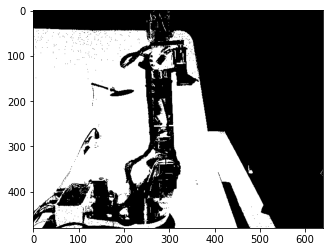

In [14]:
for x, _ in bin_train_loader:
    print(f"{x.max()}, {x.size()}, {type(x)}, {x.shape}")
    x = x.to(device)
    # ===================forward=====================
    x_hat, mu, logvar = model(x)
    im_hat = x_hat.detach().numpy()
    im_hat = im_hat.reshape((480,640))
    print(f"{im_hat.max()}, {im_hat.size}, {type(im_hat)}, {im_hat.shape}")
    plt.imshow(im_hat,cmap='gray')

    break


0.99609375, torch.Size([480, 640]), <class 'torch.Tensor'>, torch.Size([480, 640])
1.0, 307200, <class 'numpy.ndarray'>, (480, 640)


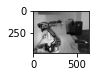

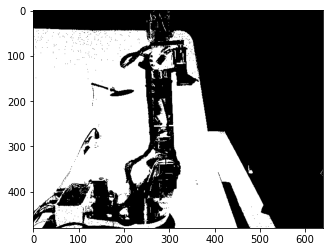

In [15]:
x_numpy = bin_train_loader.dataset[0][0]
fig = plt.figure(figsize=(1,2))
fig.add_subplot
plt.imshow(x_numpy,cmap='gray')
x = torch.from_numpy(x_numpy)
print(f"{x.max()}, {x.size()}, {type(x)}, {x.shape}")
x = x.to(device)
x_hat, mu, logvar = model(x)
im_hat = x_hat.detach().numpy()
im_hat = im_hat.reshape((480,640))
print(f"{im_hat.max()}, {im_hat.size}, {type(im_hat)}, {im_hat.shape}")
fig2 = plt.figure(2)
plt.imshow(im_hat,cmap='gray')

TypeError: Invalid shape (1, 480, 640) for image data

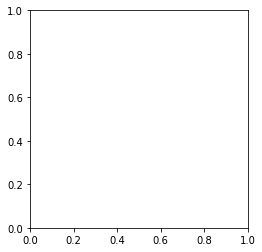